In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
file_path = 'C:/Users/Tim/Desktop/lighthouse/w6 - midterm/'
# filename = file_path+'flights.csv'

# n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
# s = 50000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s))
# df = pd.read_csv(filename,skiprows=skip)

filename = file_path+'mini_sample.csv'
df = pd.read_csv(filename)

In [3]:
data = copy.deepcopy(df)

In [4]:
# cols with > 80% missing values

drop = [
    'no_name',
    'total_add_gtime',
    'first_dep_time',
    'longest_add_gtime',
    'cancellation_code',
]

# missing 80%+ values, but apparently useful?

delay_cols = [
    'late_aircraft_delay',
    'security_delay',
    'nas_delay',
    'weather_delay',
    'carrier_delay'
]

In [5]:
# split city and country

data[['origin_city', 'origin_country']] = data['origin_city_name'].str.split(',', expand=True, n=2)

data[['dest_city', 'dest_country']] = data['dest_city_name'].str.split(',', expand=True, n=2)

# try using just city data, groupby country data?

In [6]:
# removing related carrier identifiers; commented out = used feature

carrier_identifiers = [
    'mkt_unique_carrier',
    'branded_code_share',
    #'mkt_carrier',
    'mkt_carrier_fl_num',
    'op_unique_carrier',
    'tail_num',
    'op_carrier_fl_num',
]

# removing related airport, place identifiers

place_identifiers = [
#origin identifiers
    'origin_airport_id',
    #'origin',
    'origin_city_name',
    'origin_city',
    'origin_country',
#destination identifiers
    'dest_airport_id',
    #'dest',
    'dest_city_name',
    'dest_city',
    'dest_country',
]

In [7]:
# avg flights per hr per airport -> fl traffic

data['hrly_bin'] = round(data['arr_time'],-2)
data['avg_hr_fl'] = data.groupby('dest')['hrly_bin'].transform(lambda x: len(x)/x.nunique())
data['avg_day_fl'] = data.groupby('dest')['day'].transform(lambda x: len(x)/x.nunique())
# data = data.drop(columns='hrly_bin')

In [8]:
# datetime

import datetime as dt
from datetime import date, time

In [9]:
# data['fl_date'] = pd.to_datetime(data['fl_date'])

# # month and year

# data['day_of_week'] = data['fl_date'].dt.date.isowekday()
# data['month'] = data['fl_date'].dt.month
# data['year'] = data['fl_date'].dt.year
data = data.sort_values(by=['fl_date'])

# dep_delay 7 day lag

# data['dep_delay_lag'] = data['dep_delay'].shift(7)
# # data['arr_delay_lag'] = data['arr_delay'].shift(7)

# # dep_delay 7 day mean

# data['ddl_rolling_mean'] = data['dep_delay'].rolling(window=30).mean()

# if we use classifier

# data['arr_delay_flag'] = data['arr_delay'].map(lambda x: 1 if x > 0 else 0)

data = data.drop(columns = 'fl_date')

In [10]:
data['adl_rolling_mean'] = data['arr_delay'].rolling(window=30).mean()

In [11]:
data = data.fillna(0)

In [12]:
# dep_time	          wheels_off	0.9725230213908642
# wheels_on	          arr_time	    0.9630471247128861
# crs_elapsed_time	  distance	    0.9827710593474663
# actual_elapsed_time air_time	    0.985116094313287

# flights = column of 1s

corr_drop = [
    'wheels_off',  #dep/arr time could have information on whether or not time of day affects delay
    'wheels_on',   #wheels off/on probably time spent in tarmac
    'timestamp',
    #'dist_group',
    'distance'
]

# don't use dep_delay

extra_drop = [
    'flights',
    #'origin_num_freight',
    #'origin_num_passengers',
    'crs_elapsed_time',
    'crs_arr_daytime',
    'crs_dep_daytime',
    'actual_elapsed_time',
    #'predicted_speed',
    'actual_speed',
    'dep_early_morning',
    'origin_num_intl_dep',
    'dest_num_intl_dep',
    'origin_num_intl_arr',
    'dest_num_intl_arr',
    'mean_monthly_op_carrier_delay',
    'mean_mo_delay_origin_airport',
    'mean_mo_delay_dest_airport',
    'air_time',
    'taxi_in',
    'taxi_out',
    'diverted',
    'cancelled',
    'dep_delay',
    'dep_time',
    'arr_time',
    'day_of_year'
]


data = data.drop(columns=corr_drop+extra_drop)

In [13]:
cd = data.groupby('mkt_unique_carrier').mean()['arr_delay']
cd = cd.reset_index()
cd.columns = ['mkt_unique_carrier','mean_carrier_arr_delay']
cd

,mkt_unique_carrier,mean_carrier_arr_delay
0,AA,12.695256
1,AS,14.490647
2,B6,13.136552
3,DL,13.219501
4,F9,11.224367
5,G4,14.273038
6,HA,16.506024
7,NK,11.337219
8,UA,12.960344
9,VX,14.318182


In [14]:
data = data.merge(cd, on=['mkt_unique_carrier'], how='left')

In [15]:
td = data.groupby('tail_num').mean()['arr_delay']
td = td.reset_index()
td.columns = ['tail_num','tail_num_arr_delay']
td

,tail_num,tail_num_arr_delay
0,215NV,2.250000
1,216NV,13.888889
2,217NV,-10.833333
3,218NV,18.000000
4,219NV,12.500000
...,...,...
5989,N998JE,12.000000
5990,N998NN,40.428571
5991,N999DN,15.333333
5992,N999JQ,31.000000


In [16]:
data = data.merge(td, on=['tail_num'], how='left')

In [17]:
# op_carrier, origin, dest

data['mkt_carrier'] = pd.factorize(data['mkt_carrier'])[0]
data['origin'] = pd.factorize(data['origin'])[0]
data['dest'] = pd.factorize(data['dest'])[0]

In [18]:
# remove cols

data = data.drop(columns=
                #drop+       # already dropped
                #delay_cols+ # not really sure what to do with these columns (already dropped)
                carrier_identifiers+
                place_identifiers)

In [19]:
# features 

numerical = list(data.dtypes[data.dtypes != 'object'].index)

categorical = list(data.dtypes[data.dtypes == 'object'].index)

In [20]:
categorical

['weather_type']

In [21]:
numerical

['mkt_carrier',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'arr_delay',
 'origin_fl_density',
 'dest_fl_density',
 'day',
 'month',
 'year',
 'weekday',
 'crs_arr_hour',
 'crs_dep_hour',
 'predicted_speed',
 'origin_num_passengers',
 'dest_num_passengers',
 'origin_num_freight',
 'dest_num_freight',
 'dist_group',
 'season',
 'origin_airport_size',
 'dest_airport_size',
 'mean_op_carrier_delay',
 'mean_delay_origin_airport',
 'mean_delay_dest_airport',
 'totalSnow_cm',
 'sunHour',
 'cloudcover',
 'precipMM',
 'hrly_bin',
 'avg_hr_fl',
 'avg_day_fl',
 'adl_rolling_mean',
 'mean_carrier_arr_delay',
 'tail_num_arr_delay']

In [22]:
data['totalSnow_mm'] = data['totalSnow_cm']*10
data = data.drop(columns = 'totalSnow_cm')

In [23]:
data = pd.get_dummies(data=data,columns=categorical,drop_first=True)

In [24]:
# crs_dep_time, arr_time are values in range 0-2.4k -> get hours only

data['crs_dep_hour'] = round(data['crs_dep_time']/60)
data['crs_arr_hour'] = round(data['crs_arr_time']/60)

data = data.drop(columns=['crs_dep_time','crs_arr_time'])

In [25]:
# reshuffle
data = data.sample(frac=1)
# data = data.reset_index()
# data = data[data['arr_delay']<=200]

In [26]:
X = data.drop(columns = ['arr_delay','adl_rolling_mean'])
#y = data['arr_delay']
y = data['adl_rolling_mean']

In [27]:
X.columns

Index(['mkt_carrier', 'origin', 'dest', 'origin_fl_density', 'dest_fl_density',
       'day', 'month', 'year', 'weekday', 'crs_arr_hour', 'crs_dep_hour',
       'predicted_speed', 'origin_num_passengers', 'dest_num_passengers',
       'origin_num_freight', 'dest_num_freight', 'dist_group', 'season',
       'origin_airport_size', 'dest_airport_size', 'mean_op_carrier_delay',
       'mean_delay_origin_airport', 'mean_delay_dest_airport', 'sunHour',
       'cloudcover', 'precipMM', 'hrly_bin', 'avg_hr_fl', 'avg_day_fl',
       'mean_carrier_arr_delay', 'tail_num_arr_delay', 'totalSnow_mm',
       'weather_type_Rainy', 'weather_type_Snowy', 'weather_type_Sunny'],
      dtype='object')

In [28]:
# X.to_csv('X.csv')

In [29]:
# X to scale
scaling = [
    'origin_num_passengers', 'dest_num_passengers', 'origin_num_freight',
    'dest_num_freight', 'season', 'origin_airport_size',
    'dest_airport_size', 'mean_op_carrier_delay',
    'mean_delay_origin_airport', 'mean_delay_dest_airport', 'sunHour',
    'cloudcover', 'precipMM', 'mean_carrier_arr_delay', 'tail_num_arr_delay', 'totalSnow_mm',
]

In [30]:
# scale/normalize

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#scaling

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

scaled = scaler.fit_transform(X[scaling])

In [31]:
for i in range(len(scaling)):
    X[scaling[i]] = scaled[:,i]

In [32]:
X.head()

,mkt_carrier,origin,dest,origin_fl_density,dest_fl_density,day,month,year,weekday,crs_arr_hour,...,precipMM,hrly_bin,avg_hr_fl,avg_day_fl,mean_carrier_arr_delay,tail_num_arr_delay,totalSnow_mm,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny
2593,3,19,85,22,44,11,2,2018,6,34.0,...,-0.391660,1300,4.142857,3.107143,-2.550418,-0.712091,-0.109994,0,0,1
7752,8,0,48,8,35,27,4,2018,4,15.0,...,-0.329612,1900,15.304348,11.733333,-0.290095,-0.308568,-0.109994,1,0,0
22030,2,43,24,5,21,20,11,2018,1,35.0,...,-0.158982,1200,72.208333,55.903226,-0.659250,-0.871654,0.322849,0,1,0
40727,0,16,30,24,25,17,8,2019,5,38.0,...,-0.391660,900,5.857143,4.241379,-0.290095,-1.142428,-0.109994,0,0,1
6181,1,96,6,1,6,6,4,2018,4,31.0,...,1.361178,1000,100.320000,80.903226,0.070800,0.120670,-0.109994,1,0,0


<AxesSubplot:xlabel='adl_rolling_mean', ylabel='Count'>

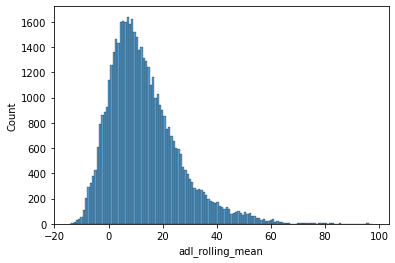

In [33]:
sns.histplot(y)

<AxesSubplot:xlabel='arr_delay', ylabel='Count'>

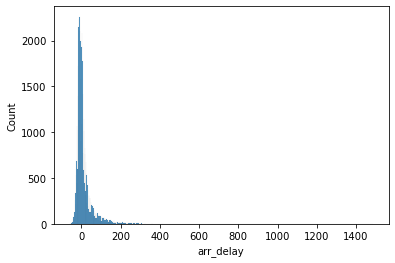

In [34]:
sns.histplot(df['arr_delay'])

<AxesSubplot:ylabel='adl_rolling_mean'>

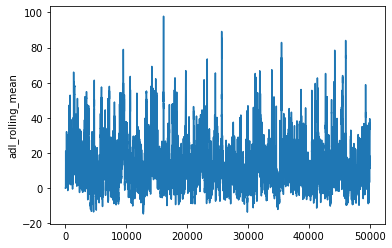

In [35]:
sns.lineplot(y=y,x=y.index)

<AxesSubplot:ylabel='arr_delay'>

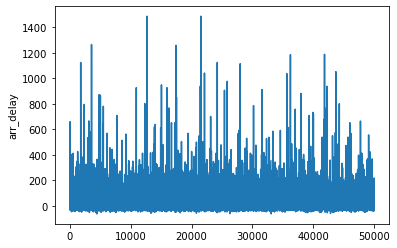

In [36]:
sns.lineplot(y=df['arr_delay'],x=df.index)

In [37]:
y_ = y-y.mean()

In [38]:
from scipy.stats import boxcox
from numpy import log

In [39]:
# splitting

from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,train_size=0.7) #full scaled X
x_train, x_test, y_train, y_test = train_test_split(X,y_,train_size=0.7)  #using partially scaled X
# x_train, x_test, y_train, y_test = train_test_split(X_scaled,y_,train_size=0.7) #full scaled X, boxcox y

In [40]:
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [41]:
# gridsearch cv done from previous notebook

In [42]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

model = XGBRegressor(objective ='reg:squarederror',
                     booster='gbtree',
                     learning_rate = 0.1,
                     colsample_bytree = 1,
                     max_depth = 10, 
                     alpha = 10,
                     n_estimators = 100)
model.fit(x_train,y_train)

train_score = cross_val_score(model,x_train,y_train,cv=10)
print(round(train_score.mean(),2)*100)

49.0


In [43]:
y_pred = model.predict(x_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
print(metrics.r2_score(y_test,y_pred))

RMSE: 9.252154
0.5096234215227564


In [44]:
# from sklearn.feature_selection import SelectFromModel

# # select features using threshold
# selection = SelectFromModel(model, prefit=True)
# select_X_train = selection.transform(x_train)
# # train model
# selection_model = XGBRegressor(objective ='reg:squarederror',
#                     booster='gbtree',
#                     learning_rate = 0.1,
#                     max_depth = 10, 
#                     alpha = 10,
#                     n_estimators = 100)
# selection_model.fit(select_X_train, y_train)

# select_X_test = selection.transform(x_test)
# y_pred = selection_model.predict(select_X_test)
# print(metrics.r2_score(y_test,y_pred))

In [45]:
from numpy import sort

In [46]:
# thresholds = sort(model.feature_importances_)
# for thresh in thresholds:
# 	# select features using threshold
# 	selection = SelectFromModel(model, threshold=thresh, prefit=True)
# 	select_X_train = selection.transform(x_train)
# 	# train model
# 	selection_model = XGBRegressor()
# 	selection_model.fit(select_X_train, y_train)
# 	# eval model
# 	select_X_test = selection.transform(x_test)
# 	predictions = selection_model.predict(select_X_test)
# 	accuracy = metrics.r2_score(y_test, predictions)
# 	print("Thresh=%.3f, n=%d, R2: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [47]:
model.feature_importances_

array([0.00818239, 0.01031796, 0.0112352 , 0.01209741, 0.01246096,
       0.13294035, 0.16024254, 0.10985282, 0.12090211, 0.01304068,
       0.01412845, 0.01514277, 0.01716918, 0.01594995, 0.01572931,
       0.01606398, 0.0128184 , 0.06283159, 0.017274  , 0.00772593,
       0.01294125, 0.01519329, 0.01686044, 0.01365635, 0.01558931,
       0.01364501, 0.01638097, 0.01553988, 0.01761027, 0.01452886,
       0.01965229, 0.01371101, 0.01429822, 0.        , 0.01428689],
      dtype=float32)

In [48]:
selection_model.feature_importances_

NameError: name 'selection_model' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error

testing_error = mean_squared_error(y_test,y_pred)
print(testing_error)

exp_var = metrics.explained_variance_score(y_test,y_pred)
print(exp_var)

In [ ]:
# cv_results = cross_validate(selection_model,X,y,cv=10,scoring='r2',n_jobs=-1)

# print(cv_results['test_score'])

In [ ]:
# """
# ways to improve model 

# -more weather data
#     -wind speed, 
#     -use all data - try iterative training using pickles (xgb)
    
# -efficiency 
#     -pipelines
# """

In [ ]:
# import pickle
# with open('xgboost.pickle','wb') as f:
#     pickle.dump(selection_model,f)

In [49]:
test_data = pd.read_csv(file_path+'final_test_cleaned.csv')

In [50]:
set(X.columns)-set(test_data.columns)

set()

In [51]:
test_data.fillna(test_data.mean())

,Unnamed: 0,index,mkt_carrier,origin,dest,sunHour,cloudcover,precipMM,day,month,...,dest_num_freight,hrly_bin,avg_hr_fl,avg_day_fl,mean_carrier_arr_delay,tail_num_arr_delay,totalSnow_mm,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny
0,0,35318,0,157,12,7.0,30,0.1,7,1,...,2.448866e+08,2000,38.560000,137.714286,12.695256,22.857143,0.0,1,0,0
1,1,111773,3,38,77,8.7,6,0.0,1,1,...,1.118000e+09,1300,95.380952,286.142857,13.773191,2.000000,0.0,0,0,1
2,2,92664,1,2,53,8.7,25,0.0,5,1,...,3.397715e+08,1700,120.920000,431.857143,12.960344,-1.200000,0.0,0,0,1
3,3,130708,4,139,106,5.7,66,1.1,3,1,...,1.126954e+06,1200,4.619048,13.857143,13.136552,-6.750000,0.0,1,0,0
4,4,112873,3,44,87,8.7,29,0.0,5,1,...,2.927626e+06,2200,110.720000,395.428571,11.224367,2.333333,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150494,150494,140772,3,72,277,8.7,0,0.0,5,1,...,3.474204e+07,2200,28.952381,86.857143,13.773191,6.090909,0.0,0,0,1
150495,150495,108267,6,73,77,8.7,20,0.2,5,1,...,1.118000e+09,1700,95.380952,286.142857,12.695256,48.200000,0.0,1,0,0
150496,150496,102935,0,130,72,3.5,78,7.5,2,1,...,9.908762e+08,1200,22.636364,71.142857,13.219501,-1.000000,0.0,1,0,0
150497,150497,32373,6,143,11,8.7,34,0.4,6,1,...,8.378688e+07,1800,105.863636,332.714286,13.219501,11.214286,3.0,0,1,0


In [52]:
test_data = test_data.drop(columns = ['Unnamed: 0','index'])

In [53]:
test_cols = ['mkt_carrier', 'origin', 'dest', 'origin_fl_density',
       'dest_fl_density', 'day', 'month', 'year', 'weekday', 'crs_arr_hour',
       'crs_dep_hour', 'predicted_speed', 'origin_num_passengers',
       'dest_num_passengers', 'origin_num_freight', 'dest_num_freight',
       'dist_group', 'season', 'origin_airport_size', 'dest_airport_size',
       'mean_op_carrier_delay', 'mean_delay_origin_airport',
       'mean_delay_dest_airport', 'sunHour', 'cloudcover', 'precipMM',
       'hrly_bin', 'avg_hr_fl', 'avg_day_fl', 'mean_carrier_arr_delay',
       'tail_num_arr_delay', 'totalSnow_mm', 'weather_type_Rainy',
       'weather_type_Snowy', 'weather_type_Sunny']

X_test = test_data[test_cols]

# model.get_booster().feature_names = ['index', 'mkt_carrier', 'origin', 'dest', 'origin_fl_density',
#        'dest_fl_density', 'day', 'month', 'year', 'weekday', 'crs_arr_hour',
#        'crs_dep_hour', 'predicted_speed', 'origin_num_passengers',
#        'dest_num_passengers', 'origin_num_freight', 'dest_num_freight',
#        'dist_group', 'season', 'origin_airport_size', 'dest_airport_size',
#        'mean_op_carrier_delay', 'mean_delay_origin_airport',
#        'mean_delay_dest_airport', 'sunHour', 'cloudcover', 'precipMM',
#        'hrly_bin', 'avg_hr_fl', 'avg_day_fl', 'mean_carrier_arr_delay',
#        'tail_num_arr_delay', 'totalSnow_mm', 'weather_type_Rainy',
#        'weather_type_Snowy', 'weather_type_Sunny']

test_pred = model.predict(X_test)

print(test_pred)



[ 3.6155322   3.111008   -6.7393246  ... -0.44650072  0.26889336
  1.0908111 ]


<AxesSubplot:ylabel='Count'>

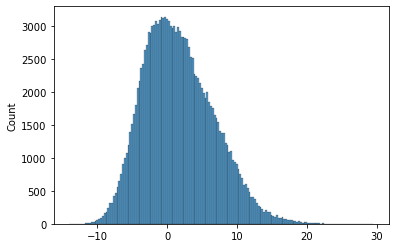

In [54]:
sns.histplot(test_pred)

In [55]:
flights_test = pd.read_csv(file_path+'flights_test.csv')
flights_test['test_pred'] = pd.Series(test_pred)
# flights_test.to_csv('flights_test_pred4.csv')

<AxesSubplot:ylabel='test_pred'>

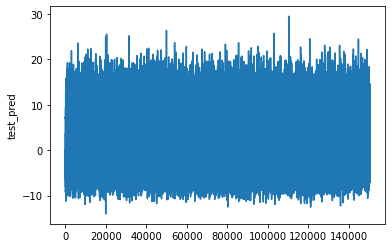

In [56]:
sns.lineplot(y=flights_test['test_pred'],x=flights_test.index)